In [ ]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [ ]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/ColabNotebooks')

# # CNN Class
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
#%% Import data

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Resize(64),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization with recommended values
                       ])

# import the data and apply the transform
dataset_train = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
# dataset_test  = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False,  transform=transform)

# =========== select only 3 classes ===========
# s = ['Trouser', 'Pullover', 'Sneaker']
# l = dataset_train.classes
# d = np.array([i for i in range(len(l)) if l[i] in s])
# t = [np.where(dataset_train.targets==d[i])[0] for i in range(len(d))]
# flat_list = np.array([item for sublist in t for item in sublist])

# dataset_train.data = dataset_train.data[flat_list]
# dataset_train.targets = dataset_train.targets[flat_list]

# ============================================

print(f'dataset_train: {dataset_train.data.shape}')
# print(f'dataset_test: {dataset_test.data.shape}')

# convert to dataloaders
batchsize = 100
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
# dataloader_test  = DataLoader(dataset_test, batch_size=256)

Compose(
    ToTensor()
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Text(0, 0.5, 'torch dataset')

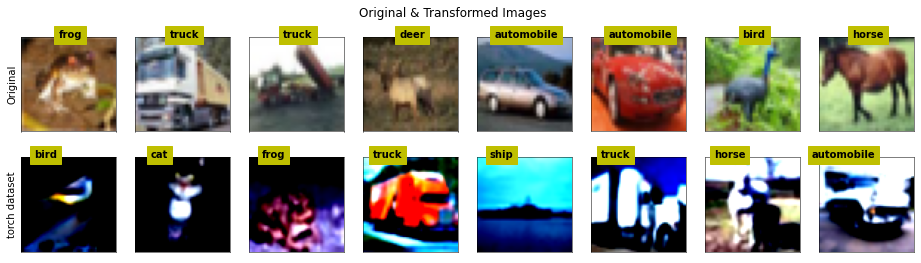

In [ ]:
#%% plot some data in DataLoader

# import data from the dataloader
X, y = next(iter(dataloader_train))


# create a figure
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Original & Transformed Images')

# draw 8 first images
for i in range(8):

    # draw
    img = torch.tensor(dataset_train.data[i])
    axs[0, i].imshow(img)
    
    label = dataset_train.classes[dataset_train.targets[i]]
    axs[0, i].text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    
    img = X[i].permute(1, 2, 0)
    axs[1, i].imshow(img)

    label = dataset_train.classes[y[i]]
    axs[1, i].text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    

    for row in range(2):
      axs[row, i].set_xticks([])
      axs[row, i].set_yticks([])

# row labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('torch dataset')

(array([ 3424.,  7318.,  8592., 12797., 16490., 19860., 22376., 24934.,
        26084., 28229., 30607., 30802., 32323., 34755., 34883., 35248.,
        35967., 36845., 38388., 38548., 38095., 37788., 37228., 38511.,
        36537., 33979., 34906., 35078., 34881., 33516., 31629., 30098.,
        29006., 27208., 23668., 21803., 19360., 17923., 18827., 16043.,
        16167., 16128., 13280., 12758., 15359., 11898.,  6522., 10646.,
         4329.,  7159.]),
 array([-2.1179, -2.0227, -1.9276, -1.8324, -1.7373, -1.6421, -1.547 ,
        -1.4518, -1.3566, -1.2615, -1.1663, -1.0712, -0.976 , -0.8808,
        -0.7857, -0.6905, -0.5954, -0.5002, -0.4051, -0.3099, -0.2147,
        -0.1196, -0.0244,  0.0707,  0.1659,  0.261 ,  0.3562,  0.4514,
         0.5465,  0.6417,  0.7368,  0.832 ,  0.9272,  1.0223,  1.1175,
         1.2126,  1.3078,  1.4029,  1.4981,  1.5933,  1.6884,  1.7836,
         1.8787,  1.9739,  2.0691,  2.1642,  2.2594,  2.3545,  2.4497,
         2.5448,  2.64  ], dtype=float32),
 <

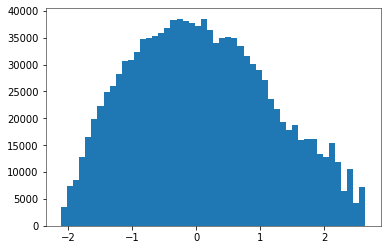

In [ ]:
# check value in the img

# plot hist
x = X[:].view(-1, 1).detach().numpy()
plt.hist(x, 50)


Models Classes

In [ ]:
class discriminatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    # print
    self.print = False

    # convolution layers
    self.conv1 = nn.Conv2d(  3,  64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64, 128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,   1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self, x):

    print('\n####### discriminatorNet #######') if self.print else None

    x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
    print(x.shape) if self.print else None

    x = F.leaky_relu(self.conv2(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn2(x)

    x = F.leaky_relu(self.conv3(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn3(x)

    x = F.leaky_relu(self.conv4(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn4(x)

    x = torch.sigmoid(self.conv5(x))
    print(x.shape) if self.print else None
    x = x.view(-1, 1)

    # one-time print
    self.print = False

    return x

In [ ]:
class generatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    # print
    self.print = False

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128,  64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,    3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self, x):

    print('\n####### generatorNet #######') if self.print else None

    x = F.relu( self.bn1(self.conv1(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn2(self.conv2(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn3(self.conv3(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn4(self.conv4(x)) )
    print(x.shape) if self.print else None

    x = torch.tanh( self.conv5(x) )
    print(x.shape) if self.print else None

    # one-time print
    self.print = False

    return x

Models Instance & params

In [ ]:
# models instance
d_net = discriminatorNet().to(device)
d_net.print = True
g_net = generatorNet().to(device)
g_net.print = True

# loss function
loss_fun = nn.BCELoss()

# optimizer
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999)) # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# training epochs
epochs = 40


In [ ]:
# init vars to store results
d_loss = torch.zeros((epochs, len(dataloader_train))) # for discriminator
g_loss = torch.zeros((epochs, len(dataloader_train))) # for generator
d_pred_train_d = torch.zeros((epochs, len(dataloader_train))) # discriminator prediction on training discriminator
d_pred_train_g = torch.zeros((epochs, len(dataloader_train))) # discriminator prediction on training generator

Train model

In [ ]:
for epochi in range(epochs):

  d_loss_batch = torch.zeros((len(dataloader_train))) # for discriminator
  g_loss_batch = torch.zeros((len(dataloader_train))) # for generator
  d_pred_train_d_batch = torch.zeros((len(dataloader_train))) # discriminator prediction on training discriminator
  d_pred_train_g_batch = torch.zeros((len(dataloader_train))) # discriminator prediction on training generator  

  batch = 0
  for real_img, _ in dataloader_train:

    if device:
        # data to GPU
        real_img = real_img.to(device)
        # y_batch_true_train = y_batch_true_train.to(device)

    
    # labels for REAL and FAKE images
    real_labels = torch.ones(batchsize, 1).to(device) # all labels are 1
    fake_labels = torch.zeros(batchsize, 1).to(device) # all labels are 0


    # ----** Train discriminator **----

    # forward pass, loss: **REAL** pictures
    pred_real   = d_net(real_img) # REAL images into discriminator
    d_loss_real = loss_fun(pred_real, real_labels) 
    
    # forward pass, loss: **FAKE** pictures
    # FAKE images
    fake_img = torch.randn(batchsize, 100, 1, 1).to(device)
    g_fake_img = g_net(fake_img) # output from generator 
    pred_fake   = d_net(g_fake_img) # FAKE images into discriminator
    d_loss_fake = loss_fun(pred_fake, fake_labels) 
    
    # loss
    d_comb_loss = d_loss_real + d_loss_fake # combine loss
    d_loss_batch[batch]  = d_comb_loss.item()
    d_pred_train_d_batch[batch] = torch.sum( (pred_real>0.5).float() ).detach() / len(pred_real)

    # backprop
    d_optimizer.zero_grad()
    d_comb_loss.backward()
    d_optimizer.step()


    # ----** Train generator **----

    # forward pass, loss: **FAKE** pictures with **REAL** labels
    fake_img = torch.randn(batchsize, 100, 1, 1).to(device)
    g_fake_img = g_net(fake_img) # output from generator
    pred_fake = d_net(g_fake_img)

    # loss
    g_pred_loss = loss_fun(pred_fake, real_labels)
    g_loss_batch[batch]  = g_pred_loss.item()
    d_pred_train_g_batch[batch] = torch.sum( (pred_fake>0.5).float() ).detach() / len(pred_fake)
    
    # backprop
    g_optimizer.zero_grad()
    g_pred_loss.backward()
    g_optimizer.step()

    # batch increment
    batch += 1


  # average loss over batch
  d_loss[epochi, :] = d_loss_batch
  g_loss[epochi, :] = g_loss_batch
  d_pred_train_d[epochi, :] = d_pred_train_d_batch
  d_pred_train_g[epochi, :] = d_pred_train_g_batch
  
  # print out a status message
  if (epochi+1)%10==0:
    msg = f'Finished epoch {epochi+1}/{epochs}'
    sys.stdout.write('\r' + msg)



####### discriminatorNet #######
torch.Size([100, 64, 32, 32])
torch.Size([100, 128, 16, 16])
torch.Size([100, 256, 8, 8])
torch.Size([100, 512, 4, 4])
torch.Size([100, 1, 1, 1])

####### generatorNet #######
torch.Size([100, 512, 4, 4])
torch.Size([100, 256, 8, 8])
torch.Size([100, 128, 16, 16])
torch.Size([100, 64, 32, 32])
torch.Size([100, 3, 64, 64])
Finished epoch 40/40

Result

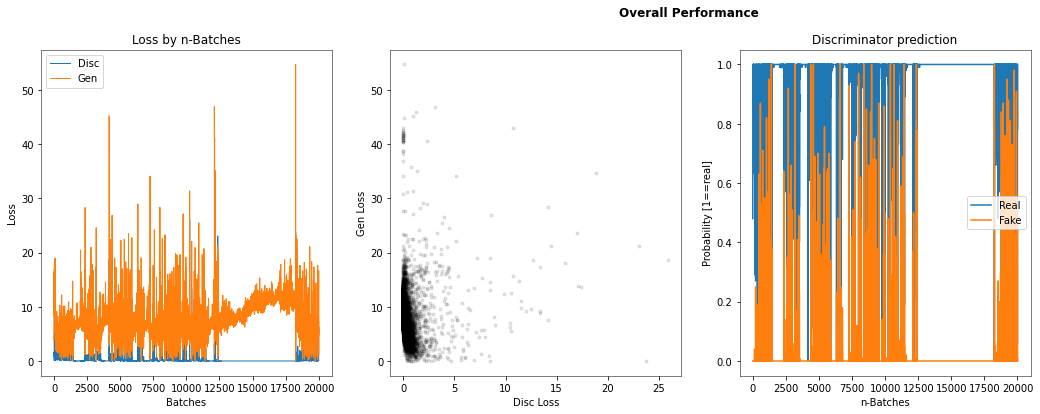

In [ ]:
#%% plot model performance


# plot
fig = plt.figure(figsize=(24, 6))
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot losses
plt.subplot(1, 4, 1)
y_plot_1 = np.array(d_loss.ravel())
y_plot_2 = np.array(g_loss.ravel())
plt.plot(np.arange(0, len(y_plot_1)), y_plot_1, linewidth=1)
plt.plot(np.arange(0, len(y_plot_2)), y_plot_2, linewidth=1)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss by n-Batches')
plt.legend(['Disc', 'Gen'])
# plt.xlim([0, 1000])


# plot losses
plt.subplot(1, 4, 2)
y_plot_1 = np.array(d_loss.ravel())
y_plot_2 = np.array(g_loss.ravel())
plt.plot(y_plot_1, y_plot_2, 'k.', alpha=0.1)
plt.xlabel('Disc Loss')
plt.ylabel('Gen Loss')


# plot discriminator output
plt.subplot(1, 4, 3)
y_plot_1 = np.array(d_pred_train_d.ravel())
y_plot_2 = np.array(d_pred_train_g.ravel())
plt.plot(np.arange(0, len(y_plot_1)), y_plot_1)
plt.plot(np.arange(0, len(y_plot_2)), y_plot_2)
plt.title('Discriminator prediction')
plt.xlabel('n-Batches')
plt.ylabel('Probability [1==real]')
plt.legend(['Real', 'Fake'])
# plt.xlim([4000, 4100])

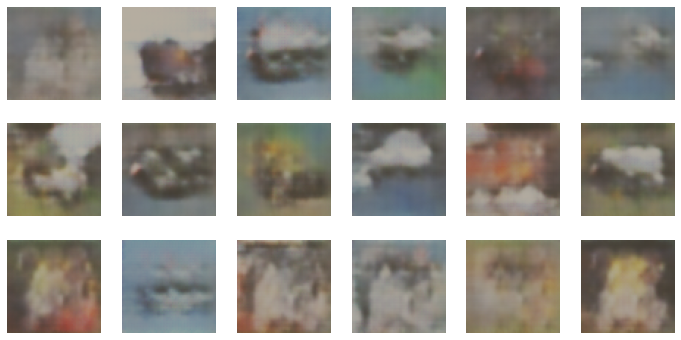

In [ ]:
# generate the images from the generator network

# switch to eval mode
g_net.eval()

# create fake data
fake_data = g_net(torch.randn(batchsize, 100, 1, 1).to(device)).cpu()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# reverse normalize
for i in range(len(fake_data)):
  for dim in range(fake_data[i].shape[0]):
    fake_data[i, dim] = (fake_data[i, dim]*std[dim]) + mean[dim]

# plot
fig, axs = plt.subplots(3, 6, figsize=(12, 6))

for i, ax in enumerate(axs.flatten()):

  img = fake_data[i].permute(1, 2, 0)
  ax.imshow(img.detach().numpy())
  ax.axis('off')